In [16]:
# Uncomment the line below to install needed libraries and modules if not available on the system
# !pip install matplotlib, numpy, seaborn, sqlite3, fireducks, pandas, python-dotenv, pprint, warnings

In [17]:
# Import needed modules
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import sqlite3
import sys
import warnings
try:
    import fireducks.pandas as pd
except ImportError:
    import pandas as pd
    pd.set_option("mode.copy_on_write", True)
from dotenv import load_dotenv
from IPython.core.display import HTML
from IPython.display import display
from matplotlib import rcParams
from os.path import expanduser, realpath
from pprint import pprint

In [18]:
# Monkey patching NumPy for compatibility with version >= 1.24
np.float = np.float64
np.int = np.int_
np.object = np.object_
np.bool = np.bool_

In [19]:
# Define constants
GOLDEN_RATIO = 1.618033989
FIG_WIDTH = 12
FIG_HEIGHT = FIG_WIDTH / GOLDEN_RATIO
FIG_SIZE = (FIG_WIDTH, FIG_HEIGHT)
FIG_DPI = 72
RANDOM_SAMPLE_SIZE = 13
RANDOM_SEED = 42
ALPHA_VALUE = 0.05

In [20]:
# Plotting parameters
rcParams["figure.figsize"] = FIG_SIZE
rcParams["figure.dpi"] = FIG_DPI
rcParams["savefig.format"] = "svg"

In [21]:
load_dotenv(".env")

from utils.utils import table_snapshot, display_table_exec_result, create_sql_connection, execute_on_database, standardise_column_names

In [22]:
# Get database connection details from environmental variables
HOST_NAME = os.environ.get("DB_HOST")
USER_NAME = os.environ.get("DB_USER")
USER_PASSWORD = os.environ.get("DB_PASSWORD")
DB_PORT = os.environ.get("DB_PORT")
DB_NAME = os.environ.get("DB_NAME")

In [23]:
# Path to Combo SQLite DB
print(f"sqlite3 module version: {sqlite3.version}")
print(f"SQLite engine version: {sqlite3.sqlite_version}")
PATH_TO_SQLITE_DB = "../../../../zzz_personal/.assets/data/000_common_dataset/datanerd-jobs-dataset-in-sqlite.db"
real_path_to_db = realpath(expanduser(PATH_TO_SQLITE_DB))

sqlite3 module version: 2.6.0
SQLite engine version: 3.44.1


In [24]:
list_all_sqlite_tables_query = """
SELECT
    name
FROM
    sqlite_master
WHERE
    type = 'table';
"""

In [25]:
sqlite_result = execute_on_database(
    db_path=real_path_to_db, sql_query=list_all_sqlite_tables_query
)
table_snapshot("job_postings_fact", db_path=real_path_to_db)
display(sqlite_result)
pprint(pd.DataFrame(sqlite_result), width=59, compact=True)

Connection to SQLite DB using SQLAlchemy successful!
Database operation successful!


,ulid_uuidv7,job_id,company_id,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_rate,salary_year_avg,salary_hour_avg,created_at,updated_at,deleted_at
0,None,0,0,Data Analyst,Marketing Data Analyst,Anywhere,via LinkedIn,Full-time,1,Serbia,2023-09-25 17:46:06,0,0,Serbia,None,None,NaN,2025-07-13 09:52:10,2025-07-13 09:52:10,None
1,None,55,1,Cloud Engineer,Storage and Virtualization Engineer,"Kuwait City, Kuwait",via Trabajo.org,Full-time,0,Kuwait,2023-07-30 17:49:18,1,0,Kuwait,None,None,NaN,2025-07-13 09:52:10,2025-07-13 09:52:10,None
2,None,66,2,Data Analyst,Data Analyst et Scientist F/H,"Paris, France",via Emplois Trabajo.org,Full-time,0,France,2023-07-28 17:28:01,0,0,France,None,None,NaN,2025-07-13 09:52:10,2025-07-13 09:52:10,None
3,None,76,3,Data Engineer,Data Engineer,"Denver, CO",via LinkedIn,Contractor,0,"Illinois, United States",2023-04-03 17:14:45,0,0,United States,hour,None,70.0,2025-07-13 09:52:10,2025-07-13 09:52:10,None
4,None,81,4,Data Engineer,Data Engineer,Anywhere,via LinkedIn,Contractor,1,Canada,2023-03-25 17:25:20,0,0,Canada,None,None,NaN,2025-07-13 09:52:10,2025-07-13 09:52:10,None


[('company_dim',),
 ('invoices_2023_fact_table',),
 ('job_postings_fact',),
 ('skills_dim',),
 ('skills_job_dim',),
 ('sqlite_stat1',)]

                       name
0               company_dim
1  invoices_2023_fact_table
2         job_postings_fact
3                skills_dim
4            skills_job_dim
5              sqlite_stat1


In [26]:
list_all_postgres_tables_query = """
SELECT
    table_schema || '.' || table_name
FROM
    information_schema.tables
WHERE
    table_type = 'BASE TABLE'
AND
    table_schema NOT IN ('pg_catalog', 'information_schema');
"""

In [27]:
postgres_result = execute_on_database(
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    sql_query=list_all_postgres_tables_query,
    messages=False,
)

display(postgres_result)
pprint(pd.DataFrame(postgres_result), width=59, compact=True)

[('public.company_dim',),
 ('public.job_postings_fact',),
 ('public.skills_job_dim',),
 ('public.skills_dim',),
 ('public.january_jobs',),
 ('public.february_jobs',),
 ('public.march_jobs',)]

                   ?column?
0        public.company_dim
1  public.job_postings_fact
2     public.skills_job_dim
3         public.skills_dim
4       public.january_jobs
5      public.february_jobs
6         public.march_jobs


In [28]:
postgres_tables_sizes_query = """
SELECT n.nspname AS table_schema,
       c.relname AS table_name,
       c.reltuples AS rows
FROM
    pg_class c
    JOIN
    pg_namespace n 
    ON
    n.oid = c.relnamespace
WHERE
    c.relkind = 'r' AND n.nspname NOT IN ('information_schema','pg_catalog')
ORDER BY
    c.reltuples desc
;
"""

postgres_tables_sizes_result = execute_on_database(
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    sql_query=postgres_tables_sizes_query,
    messages=False,
)

display(postgres_tables_sizes_result)
pprint(pd.DataFrame(postgres_tables_sizes_result), width=59, compact=True)

[('public', 'skills_job_dim', 3669604.0),
 ('public', 'job_postings_fact', 787686.0),
 ('public', 'company_dim', 140033.0),
 ('public', 'january_jobs', 92266.0),
 ('public', 'february_jobs', 64560.0),
 ('public', 'march_jobs', 64158.0),
 ('public', 'skills_dim', 259.0)]

  table_schema         table_name       rows
0       public     skills_job_dim  3669604.0
1       public  job_postings_fact   787686.0
2       public        company_dim   140033.0
3       public       january_jobs    92266.0
4       public      february_jobs    64560.0
5       public         march_jobs    64158.0
6       public         skills_dim      259.0


In [29]:
sqlite_tables_sizes_query = """
SELECT * 
FROM
    sqlite_stat1
ORDER BY
    stat DESC
;
"""

sqlite_tables_sizes_result = execute_on_database(
    db_path=real_path_to_db, sql_query=sqlite_tables_sizes_query
)
display(sqlite_tables_sizes_result)
pprint(pd.DataFrame(sqlite_tables_sizes_result), width=59, compact=True)

Connection to SQLite DB using SQLAlchemy successful!
Database operation successful!


[('job_postings_fact', None, '787686'),
 ('invoices_2023_fact_table', None, '46477'),
 ('skills_job_dim', None, '3669604'),
 ('skills_dim', None, '259'),
 ('company_dim', None, '140033')]

                        tbl   idx     stat
0         job_postings_fact  None   787686
1  invoices_2023_fact_table  None    46477
2            skills_job_dim  None  3669604
3                skills_dim  None      259
4               company_dim  None   140033


In [32]:
# Tables in database
company_dim = "company_dim"
job_postings_fact = "job_postings_fact"
skills_dim = "skills_dim"
skills_job_dim = "skills_job_dim"

In [24]:
table_snapshot("company_dim", db_path=real_path_to_db)

,ulid_uuidv7,company_id,name,link,link_google,thumbnail,created_at,updated_at,deleted_at
0,None,0,Cryptology,None,https://www.google.com/search?sca_esv=56842508...,https://encrypted-tbn0.gstatic.com/images?q=tb...,2025-07-13 09:50:17,2025-07-13 09:50:17,None
1,None,1,Edraak,None,https://www.google.com/search?hl=en&gl=us&q=Ed...,https://encrypted-tbn0.gstatic.com/images?q=tb...,2025-07-13 09:50:17,2025-07-13 09:50:17,None
2,None,2,Groupe ADP,http://www.groupeadp.fr/,https://www.google.com/search?gl=us&hl=en&q=Gr...,https://encrypted-tbn0.gstatic.com/images?q=tb...,2025-07-13 09:50:17,2025-07-13 09:50:17,None
3,None,3,Interactive Resources - iR,None,https://www.google.com/search?q=Interactive+Re...,https://encrypted-tbn0.gstatic.com/images?q=tb...,2025-07-13 09:50:17,2025-07-13 09:50:17,None
4,None,4,Cybernetic Search,None,https://www.google.com/search?gl=us&hl=en&q=Cy...,https://encrypted-tbn0.gstatic.com/images?q=tb...,2025-07-13 09:50:17,2025-07-13 09:50:17,None


In [25]:
table_snapshot("job_postings_fact", db_path=real_path_to_db)

,ulid_uuidv7,job_id,company_id,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_rate,salary_year_avg,salary_hour_avg,created_at,updated_at,deleted_at
0,None,0,0,Data Analyst,Marketing Data Analyst,Anywhere,via LinkedIn,Full-time,1,Serbia,2023-09-25 17:46:06,0,0,Serbia,None,None,NaN,2025-07-13 09:52:10,2025-07-13 09:52:10,None
1,None,55,1,Cloud Engineer,Storage and Virtualization Engineer,"Kuwait City, Kuwait",via Trabajo.org,Full-time,0,Kuwait,2023-07-30 17:49:18,1,0,Kuwait,None,None,NaN,2025-07-13 09:52:10,2025-07-13 09:52:10,None
2,None,66,2,Data Analyst,Data Analyst et Scientist F/H,"Paris, France",via Emplois Trabajo.org,Full-time,0,France,2023-07-28 17:28:01,0,0,France,None,None,NaN,2025-07-13 09:52:10,2025-07-13 09:52:10,None
3,None,76,3,Data Engineer,Data Engineer,"Denver, CO",via LinkedIn,Contractor,0,"Illinois, United States",2023-04-03 17:14:45,0,0,United States,hour,None,70.0,2025-07-13 09:52:10,2025-07-13 09:52:10,None
4,None,81,4,Data Engineer,Data Engineer,Anywhere,via LinkedIn,Contractor,1,Canada,2023-03-25 17:25:20,0,0,Canada,None,None,NaN,2025-07-13 09:52:10,2025-07-13 09:52:10,None


In [26]:
table_snapshot("skills_dim", db_path=real_path_to_db)

,ulid_uuidv7,skill_id,skills,type,created_at,updated_at,deleted_at
0,None,0,sql,programming,2025-07-13 09:54:32,2025-07-13 09:54:32,None
1,None,1,python,programming,2025-07-13 09:54:32,2025-07-13 09:54:32,None
2,None,2,nosql,programming,2025-07-13 09:54:32,2025-07-13 09:54:32,None
3,None,3,scala,programming,2025-07-13 09:54:32,2025-07-13 09:54:32,None
4,None,4,java,programming,2025-07-13 09:54:32,2025-07-13 09:54:32,None


In [27]:
table_snapshot("skills_job_dim", db_path=real_path_to_db)

,ulid_uuidv7,job_id,skill_id,created_at,updated_at,deleted_at
0,None,0,0,2025-07-13 10:04:20,2025-07-13 10:04:20,None
1,None,0,1,2025-07-13 10:04:20,2025-07-13 10:04:20,None
2,None,66,1,2025-07-13 10:04:20,2025-07-13 10:04:20,None
3,None,76,0,2025-07-13 10:04:20,2025-07-13 10:04:20,None
4,None,76,1,2025-07-13 10:04:20,2025-07-13 10:04:20,None


# Summary of Findings from Analysis

---

### About The Project

#### Goals

1. An aspiring data nerd looking to analyse top-paying roles and skill.

2. Create SQL queries to explore this large dataset about role(s) of interest.

#### Questions to Answer

1. What are the top-paying jobs for roles that interest me?

2. What are the skills required for these top-paying roles?

3. What are the most in-demand skills for these roles?

4. What are the top skills based on salary for these roles?

5. What are the most optimal skills to learn? (Optimal: High Demand AND High Paying).

6. What are the features and discoveries related to Nigeria?

7. What are the features and discoveries related to Germany?

### Q1. What are the top-paying data analyst, data scientist and data engineer jobs? Identify the top 10 highest-paying Data Analyst/Scientist/Engineer roles that are available remotely.

In [30]:
postgres_top_data_analyst_remote_jobs_query = f"""
SELECT
    job_id,
    job_title,
    job_location,
    job_schedule_type,
    salary_year_avg,
    job_posted_date,
    name AS company_name
FROM
    job_postings_fact
    LEFT JOIN
    company_dim
    ON
    job_postings_fact.company_id = company_dim.company_id
WHERE
    job_title_short = 'Data Analyst' AND job_location = 'Anywhere' AND salary_year_avg IS NOT NULL
ORDER BY
    salary_year_avg DESC
LIMIT 10
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_top_data_analyst_remote_jobs_query,
)


,job_id,job_title,job_location,job_schedule_type,salary_year_avg,job_posted_date,company_name
0,226942,Data Analyst,Anywhere,Full-time,650000.0,2023-02-20 15:13:33,Mantys
1,547382,Director of Analytics,Anywhere,Full-time,336500.0,2023-08-23 12:04:42,Meta
2,552322,Associate Director- Data Insights,Anywhere,Full-time,255829.5,2023-06-18 16:03:12,AT&T
3,99305,"Data Analyst, Marketing",Anywhere,Full-time,232423.0,2023-12-05 20:00:40,Pinterest Job Advertisements
4,1021647,Data Analyst (Hybrid/Remote),Anywhere,Full-time,217000.0,2023-01-17 00:17:23,Uclahealthcareers
5,168310,Principal Data Analyst (Remote),Anywhere,Full-time,205000.0,2023-08-09 11:00:01,SmartAsset
6,731368,"Director, Data Analyst - HYBRID",Anywhere,Full-time,189309.0,2023-12-07 15:00:13,Inclusively
7,310660,"Principal Data Analyst, AV Performance Analysis",Anywhere,Full-time,189000.0,2023-01-05 00:00:25,Motional
8,1749593,Principal Data Analyst,Anywhere,Full-time,186000.0,2023-07-11 16:00:05,SmartAsset
9,387860,ERM Data Analyst,Anywhere,Full-time,184000.0,2023-06-09 08:01:04,Get It Recruit - Information Technology


Function: `display_table_exec_result` took --> 618377891ns (0.618s)


In [32]:
sqlite_top_data_analyst_remote_jobs_query = f"""
SELECT
    job_id,
    job_title,
    job_location,
    job_schedule_type,
    salary_year_avg,
    job_posted_date,
    name AS company_name
FROM
    job_postings_fact
    LEFT JOIN
    company_dim
    ON
    job_postings_fact.company_id = company_dim.company_id
WHERE
    job_title_short = 'Data Analyst' AND job_location = 'Anywhere' AND salary_year_avg IS NOT NULL
ORDER BY
    salary_year_avg DESC
LIMIT 10
;
"""


display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_top_data_analyst_remote_jobs_query,
)

,job_id,job_title,job_location,job_schedule_type,salary_year_avg,job_posted_date,company_name
0,226942,Data Analyst,Anywhere,Full-time,650000.0,2023-02-20 15:13:33,Mantys
1,547382,Director of Analytics,Anywhere,Full-time,336500.0,2023-08-23 12:04:42,Meta
2,552322,Associate Director- Data Insights,Anywhere,Full-time,255829.5,2023-06-18 16:03:12,AT&T
3,99305,"Data Analyst, Marketing",Anywhere,Full-time,232423.0,2023-12-05 20:00:40,Pinterest Job Advertisements
4,1021647,Data Analyst (Hybrid/Remote),Anywhere,Full-time,217000.0,2023-01-17 00:17:23,Uclahealthcareers
5,168310,Principal Data Analyst (Remote),Anywhere,Full-time,205000.0,2023-08-09 11:00:01,SmartAsset
6,731368,"Director, Data Analyst - HYBRID",Anywhere,Full-time,189309.0,2023-12-07 15:00:13,Inclusively
7,310660,"Principal Data Analyst, AV Performance Analysis",Anywhere,Full-time,189000.0,2023-01-05 00:00:25,Motional
8,1749593,Principal Data Analyst,Anywhere,Full-time,186000.0,2023-07-11 16:00:05,SmartAsset
9,387860,ERM Data Analyst,Anywhere,Full-time,184000.0,2023-06-09 08:01:04,Get It Recruit - Information Technology


Function: `display_table_exec_result` took --> 956981092ns (0.957s)


In [33]:
postgres_top_data_scientist_remote_jobs_query = f"""
SELECT
    job_id,
    job_title,
    job_location,
    job_schedule_type,
    salary_year_avg,
    job_posted_date,
    name AS company_name
FROM
    job_postings_fact
    LEFT JOIN
    company_dim
    ON
    job_postings_fact.company_id = company_dim.company_id
WHERE
    job_title_short = 'Data Scientist' AND job_location = 'Anywhere' AND salary_year_avg IS NOT NULL
ORDER BY
    salary_year_avg DESC
LIMIT 10
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_top_data_scientist_remote_jobs_query,
)


,job_id,job_title,job_location,job_schedule_type,salary_year_avg,job_posted_date,company_name
0,40145,Staff Data Scientist/Quant Researcher,Anywhere,Full-time,550000.0,2023-08-16 16:05:16,Selby Jennings
1,1714768,Staff Data Scientist - Business Analytics,Anywhere,Full-time,525000.0,2023-09-01 19:24:02,Selby Jennings
2,1131472,Data Scientist,Anywhere,Full-time,375000.0,2023-07-31 14:05:21,Algo Capital Group
3,1742633,Head of Data Science,Anywhere,Full-time,351500.0,2023-07-12 03:07:31,Demandbase
4,551497,Head of Data Science,Anywhere,Full-time,324000.0,2023-05-26 22:04:44,Demandbase
5,126218,Director Level - Product Management - Data Sci...,Anywhere,Full-time,320000.0,2023-03-26 23:46:39,Teramind
6,1161630,Director of Data Science & Analytics,Anywhere,Full-time,313000.0,2023-08-23 22:03:48,Reddit
7,38905,Principal Data Scientist,Anywhere,Full-time,300000.0,2023-11-24 14:08:44,Storm5
8,457991,Head of Battery Data Science,Anywhere,Full-time,300000.0,2023-10-02 16:40:07,Lawrence Harvey
9,129924,Director of Data Science,Anywhere,Full-time,300000.0,2023-01-21 11:09:36,Storm4


Function: `display_table_exec_result` took --> 258535346ns (0.259s)


In [34]:
sqlite_top_data_scientist_remote_jobs_query = f"""
SELECT
    job_id,
    job_title,
    job_location,
    job_schedule_type,
    salary_year_avg,
    job_posted_date,
    name AS company_name
FROM
    job_postings_fact
    LEFT JOIN
    company_dim
    ON
    job_postings_fact.company_id = company_dim.company_id
WHERE
    job_title_short = 'Data Scientist' AND job_location = 'Anywhere' AND salary_year_avg IS NOT NULL
ORDER BY
    salary_year_avg DESC
LIMIT 10
;
"""


display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_top_data_scientist_remote_jobs_query,
)

,job_id,job_title,job_location,job_schedule_type,salary_year_avg,job_posted_date,company_name
0,40145,Staff Data Scientist/Quant Researcher,Anywhere,Full-time,550000.0,2023-08-16 16:05:16,Selby Jennings
1,1714768,Staff Data Scientist - Business Analytics,Anywhere,Full-time,525000.0,2023-09-01 19:24:02,Selby Jennings
2,1131472,Data Scientist,Anywhere,Full-time,375000.0,2023-07-31 14:05:21,Algo Capital Group
3,1742633,Head of Data Science,Anywhere,Full-time,351500.0,2023-07-12 03:07:31,Demandbase
4,551497,Head of Data Science,Anywhere,Full-time,324000.0,2023-05-26 22:04:44,Demandbase
5,126218,Director Level - Product Management - Data Sci...,Anywhere,Full-time,320000.0,2023-03-26 23:46:39,Teramind
6,1161630,Director of Data Science & Analytics,Anywhere,Full-time,313000.0,2023-08-23 22:03:48,Reddit
7,457991,Head of Battery Data Science,Anywhere,Full-time,300000.0,2023-10-02 16:40:07,Lawrence Harvey
8,129924,Director of Data Science,Anywhere,Full-time,300000.0,2023-01-21 11:09:36,Storm4
9,226011,Distinguished Data Scientist,Anywhere,Full-time,300000.0,2023-08-06 11:00:43,Walmart


Function: `display_table_exec_result` took --> 324108906ns (0.324s)


In [173]:
postgres_top_data_engineer_remote_jobs_query = f"""
SELECT
    job_id,
    job_title,
    job_location,
    job_schedule_type,
    salary_year_avg,
    job_posted_date,
    name AS company_name
FROM
    job_postings_fact
    LEFT JOIN
    company_dim
    ON
    job_postings_fact.company_id = company_dim.company_id
WHERE
    job_title_short = 'Data Engineer' AND job_location = 'Anywhere' AND salary_year_avg IS NOT NULL
ORDER BY
    salary_year_avg DESC
LIMIT 10
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_top_data_engineer_remote_jobs_query,
)


,job_id,job_title,job_location,job_schedule_type,salary_year_avg,job_posted_date,company_name
0,157003,Data Engineer,Anywhere,Full-time,325000.0,2023-02-17 18:11:49,Engtal
1,21321,Data Engineer,Anywhere,Full-time,325000.0,2023-01-27 18:10:51,Engtal
2,270455,Data Engineer,Anywhere,Full-time,300000.0,2023-07-17 11:10:55,Durlston Partners
3,230458,Director of Engineering - Data Platform,Anywhere,Full-time,251000.0,2023-01-30 11:07:32,Twitch
4,561728,Data Engineer,Anywhere,Full-time,250000.0,2023-03-24 23:32:42,AI Startup
5,543728,Staff Data Engineer,Anywhere,Full-time,250000.0,2023-03-28 13:11:42,Signify Technology
6,595768,Principal Data Engineer,Anywhere,Full-time,250000.0,2023-02-14 15:24:07,Signify Technology
7,151972,Principal Data Engineer (Remote),Anywhere,Full-time,245000.0,2023-05-25 15:05:38,Movable Ink
8,204320,Staff Data Engineer,Anywhere,Full-time,245000.0,2023-01-08 15:05:16,Handshake
9,2446,Data Engineering Manager,Anywhere,Full-time,242000.0,2023-12-12 15:56:17,Meta


Function: `display_table_exec_result` took --> 294353585ns (0.294s)


In [ ]:
sqlite_top_data_engineer_remote_jobs_query = f"""
SELECT
    job_id,
    job_title,
    job_location,
    job_schedule_type,
    salary_year_avg,
    job_posted_date,
    name AS company_name
FROM
    job_postings_fact
    LEFT JOIN
    company_dim
    ON
    job_postings_fact.company_id = company_dim.company_id
WHERE
    job_title_short = 'Data Engineer' AND job_location = 'Anywhere' AND salary_year_avg IS NOT NULL
ORDER BY
    salary_year_avg DESC
LIMIT 10
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_top_data_engineer_remote_jobs_query,
)

,job_id,job_title,job_location,job_schedule_type,salary_year_avg,job_posted_date,company_name
0,21321,Data Engineer,Anywhere,Full-time,325000.0,2023-01-27 18:10:51,Engtal
1,157003,Data Engineer,Anywhere,Full-time,325000.0,2023-02-17 18:11:49,Engtal
2,270455,Data Engineer,Anywhere,Full-time,300000.0,2023-07-17 11:10:55,Durlston Partners
3,230458,Director of Engineering - Data Platform,Anywhere,Full-time,251000.0,2023-01-30 11:07:32,Twitch
4,595768,Principal Data Engineer,Anywhere,Full-time,250000.0,2023-02-14 15:24:07,Signify Technology
5,561728,Data Engineer,Anywhere,Full-time,250000.0,2023-03-24 23:32:42,AI Startup
6,543728,Staff Data Engineer,Anywhere,Full-time,250000.0,2023-03-28 13:11:42,Signify Technology
7,151972,Principal Data Engineer (Remote),Anywhere,Full-time,245000.0,2023-05-25 15:05:38,Movable Ink
8,204320,Staff Data Engineer,Anywhere,Full-time,245000.0,2023-01-08 15:05:16,Handshake
9,2446,Data Engineering Manager,Anywhere,Full-time,242000.0,2023-12-12 15:56:17,Meta


Function: `display_table_exec_result` took --> 542702028ns (0.543s)


---

### Q2. What skills are required for the top-paying data analyst, data scientist and data engineer jobs? Identify the top 10 highest-paying Data Analyst/Scientist/Engineer jobs from the first query. Add the specific skills required for these roles.

In [175]:

postgres_top_data_analyst_jobs_skills_query = f"""
WITH top_paying_jobs AS (
    SELECT
        job_id,
        job_title,
        salary_year_avg,
        name AS company_name
    FROM
        job_postings_fact
        LEFT JOIN
        company_dim
        ON
        job_postings_fact.company_id = company_dim.company_id
    WHERE
        job_title_short = 'Data Analyst' AND job_location = 'Anywhere' AND salary_year_avg IS NOT NULL
    ORDER BY
        salary_year_avg DESC
    LIMIT 10
)

SELECT
    top_paying_jobs.*,
    skills
FROM
    top_paying_jobs
    INNER JOIN
    skills_job_dim AS sjd
    ON
    top_paying_jobs.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
ORDER BY
    salary_year_avg DESC
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_top_data_analyst_jobs_skills_query,
)


,job_id,job_title,salary_year_avg,company_name,skills
0,552322,Associate Director- Data Insights,255829.5,AT&T,sql
1,552322,Associate Director- Data Insights,255829.5,AT&T,python
2,552322,Associate Director- Data Insights,255829.5,AT&T,r
3,552322,Associate Director- Data Insights,255829.5,AT&T,azure
4,552322,Associate Director- Data Insights,255829.5,AT&T,aws
...,...,...,...,...,...
61,1749593,Principal Data Analyst,186000.0,SmartAsset,tableau
62,1749593,Principal Data Analyst,186000.0,SmartAsset,gitlab
63,387860,ERM Data Analyst,184000.0,Get It Recruit - Information Technology,sql
64,387860,ERM Data Analyst,184000.0,Get It Recruit - Information Technology,python


Function: `display_table_exec_result` took --> 269410866ns (0.269s)


In [176]:

sqlite_top_data_analyst_jobs_skills_query = f"""
WITH top_paying_jobs AS (
    SELECT
        job_id,
        job_title,
        salary_year_avg,
        name AS company_name
    FROM
        job_postings_fact
        LEFT JOIN
        company_dim
        ON
        job_postings_fact.company_id = company_dim.company_id
    WHERE
        job_title_short = 'Data Analyst' AND job_location = 'Anywhere' AND salary_year_avg IS NOT NULL
    ORDER BY
        salary_year_avg DESC
    LIMIT 10
)

SELECT
    top_paying_jobs.*,
    skills
FROM
    top_paying_jobs
    INNER JOIN
    skills_job_dim AS sjd
    ON
    top_paying_jobs.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
ORDER BY
    salary_year_avg DESC
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_top_data_analyst_jobs_skills_query,
)


,job_id,job_title,salary_year_avg,company_name,skills
0,552322,Associate Director- Data Insights,255829.5,AT&T,sql
1,552322,Associate Director- Data Insights,255829.5,AT&T,python
2,552322,Associate Director- Data Insights,255829.5,AT&T,r
3,552322,Associate Director- Data Insights,255829.5,AT&T,azure
4,552322,Associate Director- Data Insights,255829.5,AT&T,databricks
...,...,...,...,...,...
61,1749593,Principal Data Analyst,186000.0,SmartAsset,tableau
62,1749593,Principal Data Analyst,186000.0,SmartAsset,gitlab
63,387860,ERM Data Analyst,184000.0,Get It Recruit - Information Technology,sql
64,387860,ERM Data Analyst,184000.0,Get It Recruit - Information Technology,python


Function: `display_table_exec_result` took --> 6359439034ns (6.359s)


In [ ]:
postgres_top_data_scientist_jobs_skills_query = f"""
WITH top_paying_jobs AS (
    SELECT
        job_id,
        job_title,
        salary_year_avg,
        name AS company_name
    FROM
        job_postings_fact
        LEFT JOIN
        company_dim
        ON
        job_postings_fact.company_id = company_dim.company_id
    WHERE
        job_title_short = 'Data Scientist' AND job_location = 'Anywhere' AND salary_year_avg IS NOT NULL
    ORDER BY
        salary_year_avg DESC
    LIMIT 10
)

SELECT
    top_paying_jobs.*,
    skills
FROM
    top_paying_jobs
    INNER JOIN
    skills_job_dim AS sjd
    ON
    top_paying_jobs.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
ORDER BY
    salary_year_avg DESC
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_top_data_scientist_jobs_skills_query,
)


,job_id,job_title,salary_year_avg,company_name,skills
0,40145,Staff Data Scientist/Quant Researcher,550000.0,Selby Jennings,python
1,40145,Staff Data Scientist/Quant Researcher,550000.0,Selby Jennings,sql
2,1714768,Staff Data Scientist - Business Analytics,525000.0,Selby Jennings,sql
3,1131472,Data Scientist,375000.0,Algo Capital Group,python
4,1131472,Data Scientist,375000.0,Algo Capital Group,java
5,1131472,Data Scientist,375000.0,Algo Capital Group,sql
6,1131472,Data Scientist,375000.0,Algo Capital Group,cassandra
7,1131472,Data Scientist,375000.0,Algo Capital Group,hadoop
8,1131472,Data Scientist,375000.0,Algo Capital Group,spark
9,1131472,Data Scientist,375000.0,Algo Capital Group,tableau


Function: `display_table_exec_result` took --> 257289972ns (0.257s)


In [ ]:
sqlite_top_data_scientist_jobs_skills_query = f"""
WITH top_paying_jobs AS (
    SELECT
        job_id,
        job_title,
        salary_year_avg,
        name AS company_name
    FROM
        job_postings_fact
        LEFT JOIN
        company_dim
        ON
        job_postings_fact.company_id = company_dim.company_id
    WHERE
        job_title_short = 'Data Scientist' AND job_location = 'Anywhere' AND salary_year_avg IS NOT NULL
    ORDER BY
        salary_year_avg DESC
    LIMIT 10
)

SELECT
    top_paying_jobs.*,
    skills
FROM
    top_paying_jobs
    INNER JOIN
    skills_job_dim AS sjd
    ON
    top_paying_jobs.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
ORDER BY
    salary_year_avg DESC
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_top_data_scientist_jobs_skills_query,
)


,job_id,job_title,salary_year_avg,company_name,skills
0,40145,Staff Data Scientist/Quant Researcher,550000.0,Selby Jennings,sql
1,40145,Staff Data Scientist/Quant Researcher,550000.0,Selby Jennings,python
2,1714768,Staff Data Scientist - Business Analytics,525000.0,Selby Jennings,sql
3,1131472,Data Scientist,375000.0,Algo Capital Group,sql
4,1131472,Data Scientist,375000.0,Algo Capital Group,python
5,1131472,Data Scientist,375000.0,Algo Capital Group,java
6,1131472,Data Scientist,375000.0,Algo Capital Group,cassandra
7,1131472,Data Scientist,375000.0,Algo Capital Group,spark
8,1131472,Data Scientist,375000.0,Algo Capital Group,hadoop
9,1131472,Data Scientist,375000.0,Algo Capital Group,tableau


Function: `display_table_exec_result` took --> 6709419997ns (6.709s)


In [ ]:
postgres_top_data_engineer_jobs_skills_query = f"""
WITH top_paying_jobs AS (
    SELECT
        job_id,
        job_title,
        salary_year_avg,
        name AS company_name
    FROM
        job_postings_fact
        LEFT JOIN
        company_dim
        ON
        job_postings_fact.company_id = company_dim.company_id
    WHERE
        job_title_short = 'Data Engineer' AND job_location = 'Anywhere' AND salary_year_avg IS NOT NULL
    ORDER BY
        salary_year_avg DESC
    LIMIT 10
)

SELECT
    top_paying_jobs.*,
    skills
FROM
    top_paying_jobs
    INNER JOIN
    skills_job_dim AS sjd
    ON
    top_paying_jobs.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
ORDER BY
    salary_year_avg DESC
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_top_data_engineer_jobs_skills_query,
)


,job_id,job_title,salary_year_avg,company_name,skills
0,21321,Data Engineer,325000.0,Engtal,python
1,21321,Data Engineer,325000.0,Engtal,pandas
2,21321,Data Engineer,325000.0,Engtal,numpy
3,21321,Data Engineer,325000.0,Engtal,pyspark
4,21321,Data Engineer,325000.0,Engtal,hadoop
5,21321,Data Engineer,325000.0,Engtal,spark
6,21321,Data Engineer,325000.0,Engtal,kafka
7,21321,Data Engineer,325000.0,Engtal,kubernetes
8,157003,Data Engineer,325000.0,Engtal,python
9,157003,Data Engineer,325000.0,Engtal,pandas


Function: `display_table_exec_result` took --> 243326033ns (0.243s)


In [ ]:
sqlite_top_data_engineer_jobs_skills_query = f"""
WITH top_paying_jobs AS (
    SELECT
        job_id,
        job_title,
        salary_year_avg,
        name AS company_name
    FROM
        job_postings_fact
        LEFT JOIN
        company_dim
        ON
        job_postings_fact.company_id = company_dim.company_id
    WHERE
        job_title_short = 'Data Engineer' AND job_location = 'Anywhere' AND salary_year_avg IS NOT NULL
    ORDER BY
        salary_year_avg DESC
    LIMIT 10
)

SELECT
    top_paying_jobs.*,
    skills
FROM
    top_paying_jobs
    INNER JOIN
    skills_job_dim AS sjd
    ON
    top_paying_jobs.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
ORDER BY
    salary_year_avg DESC
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_top_data_engineer_jobs_skills_query,
)


,job_id,job_title,salary_year_avg,company_name,skills
0,21321,Data Engineer,325000.0,Engtal,python
1,21321,Data Engineer,325000.0,Engtal,spark
2,21321,Data Engineer,325000.0,Engtal,pandas
3,21321,Data Engineer,325000.0,Engtal,numpy
4,21321,Data Engineer,325000.0,Engtal,pyspark
5,21321,Data Engineer,325000.0,Engtal,hadoop
6,21321,Data Engineer,325000.0,Engtal,kafka
7,21321,Data Engineer,325000.0,Engtal,kubernetes
8,157003,Data Engineer,325000.0,Engtal,python
9,157003,Data Engineer,325000.0,Engtal,spark


Function: `display_table_exec_result` took --> 7044313342ns (7.044s)


---

### Q3. What are the most in-demand skills? Identify the top 7 in-demand skills for a data analyst, data scientist and data engineer from all job postings.

,skills,demand_count
0,sql,92628
1,excel,67031
2,python,57326
3,tableau,46554
4,power bi,39468
5,r,30075
6,sas,28068


Function: `display_table_exec_result` took --> 1230639346ns (1.231s)


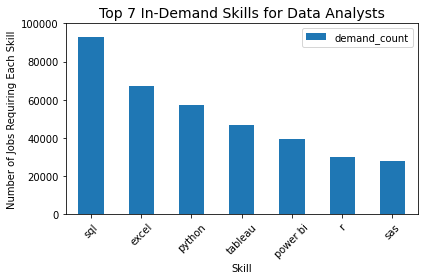

In [84]:
postgres_top_in_demand_skills_for_data_analyst_query = f"""
SELECT
    skills,
    COUNT(sjd.job_id) AS demand_count
FROM
    job_postings_fact
    INNER JOIN
    skills_job_dim AS sjd
    ON
    job_postings_fact.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Analyst'
GROUP BY
    skills
ORDER BY
    demand_count DESC
LIMIT 7
;
"""

postgres_top_in_demand_skills_for_data_analyst_query_result = display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_top_in_demand_skills_for_data_analyst_query,
    return_df=True
)

postgres_top_in_demand_skills_for_data_analyst_query_result.plot.bar(x="skills", y="demand_count")
plt.ylim(0, 100000)
plt.xticks(rotation=45)
plt.xlabel("Skill")
plt.ylabel("Number of Jobs Requiring Each Skill")
plt.title("Top 7 In-Demand Skills for Data Analysts", fontsize=14)
plt.tight_layout()

In [ ]:
sqlite_top_in_demand_skills_for_data_analyst_query = f"""
SELECT
    skills,
    COUNT(sjd.job_id) AS demand_count
FROM
    job_postings_fact
    INNER JOIN
    skills_job_dim AS sjd
    ON
    job_postings_fact.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Analyst'
GROUP BY
    skills
ORDER BY
    demand_count DESC
LIMIT 7
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_top_in_demand_skills_for_data_analyst_query,
)

,skills,demand_count
0,sql,92628
1,excel,67031
2,python,57326
3,tableau,46554
4,power bi,39468
5,r,30075
6,sas,28068


Function: `display_table_exec_result` took --> 35746075851ns (35.746s)


,skills,demand_count
0,python,114016
1,sql,79174
2,r,59754
3,sas,29642
4,tableau,29513
5,aws,26311
6,spark,24353


Function: `display_table_exec_result` took --> 1388816137ns (1.389s)


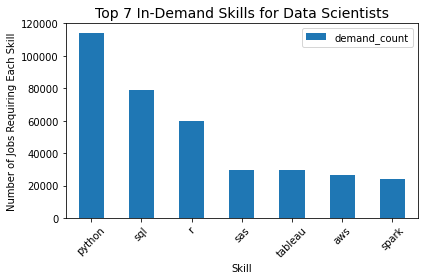

In [86]:
postgres_top_in_demand_skills_for_data_scientist_query = f"""
SELECT
    skills,
    COUNT(sjd.job_id) AS demand_count
FROM
    job_postings_fact
    INNER JOIN
    skills_job_dim AS sjd
    ON
    job_postings_fact.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Scientist'
GROUP BY
    skills
ORDER BY
    demand_count DESC
LIMIT 7
;
"""

postgres_top_in_demand_skills_for_data_scientist_query_result = display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_top_in_demand_skills_for_data_scientist_query,
    return_df=True
)

postgres_top_in_demand_skills_for_data_scientist_query_result.plot.bar(x="skills", y="demand_count")
plt.ylim(0, 120000)
plt.xticks(rotation=45)
plt.xlabel("Skill")
plt.ylabel("Number of Jobs Requiring Each Skill")
plt.title("Top 7 In-Demand Skills for Data Scientists", fontsize=14)
plt.tight_layout()

In [ ]:
sqlite_top_in_demand_skills_for_data_scientist_query = f"""
SELECT
    skills,
    COUNT(sjd.job_id) AS demand_count
FROM
    job_postings_fact
    INNER JOIN
    skills_job_dim AS sjd
    ON
    job_postings_fact.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Scientist'
GROUP BY
    skills
ORDER BY
    demand_count DESC
LIMIT 7
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_top_in_demand_skills_for_data_scientist_query,
)

,skills,demand_count
0,python,114016
1,sql,79174
2,r,59754
3,sas,29642
4,tableau,29513
5,aws,26311
6,spark,24353


Function: `display_table_exec_result` took --> 32342596887ns (32.343s)


,skills,demand_count
0,sql,113375
1,python,108265
2,aws,62174
3,azure,60823
4,spark,53789
5,java,35642
6,kafka,29163


Function: `display_table_exec_result` took --> 1605847796ns (1.606s)


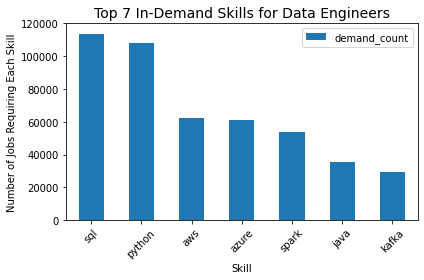

In [88]:
postgres_top_in_demand_skills_for_data_engineer_query = f"""
SELECT
    skills,
    COUNT(sjd.job_id) AS demand_count
FROM
    job_postings_fact
    INNER JOIN
    skills_job_dim AS sjd
    ON
    job_postings_fact.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Engineer'
GROUP BY
    skills
ORDER BY
    demand_count DESC
LIMIT 7
;
"""

postgres_top_in_demand_skills_for_data_engineer_query_result = display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_top_in_demand_skills_for_data_engineer_query,
    return_df=True
)

postgres_top_in_demand_skills_for_data_engineer_query_result.plot.bar(x="skills", y="demand_count")
plt.ylim(0, 120000)
plt.xticks(rotation=45)
plt.xlabel("Skill")
plt.ylabel("Number of Jobs Requiring Each Skill")
plt.title("Top 7 In-Demand Skills for Data Engineers", fontsize=14)
plt.tight_layout()

In [ ]:
sqlite_top_in_demand_skills_for_data_engineer_query = f"""
SELECT
    skills,
    COUNT(sjd.job_id) AS demand_count
FROM
    job_postings_fact
    INNER JOIN
    skills_job_dim AS sjd
    ON
    job_postings_fact.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Engineer'
GROUP BY
    skills
ORDER BY
    demand_count DESC
LIMIT 7
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_top_in_demand_skills_for_data_engineer_query,
)

,skills,demand_count
0,sql,113375
1,python,108265
2,aws,62174
3,azure,60823
4,spark,53789
5,java,35642
6,kafka,29163


Function: `display_table_exec_result` took --> 35227797172ns (35.228s)


---

### Q4. What are the top skills based on salary? Look at the average salary associated with each skill for data analyst, data scientist and data engineer positions regardless of location.

In [188]:
postgres_top_data_analyst_skills_based_on_salary_query = f"""
SELECT
    skills,
    ROUND(AVG(salary_year_avg), 0) AS avg_salary
FROM
    job_postings_fact
    INNER JOIN
    skills_job_dim AS sjd
    ON
    job_postings_fact.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Analyst' AND salary_year_avg IS NOT NULL
GROUP BY
    skills
ORDER BY
    avg_salary DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_top_data_analyst_skills_based_on_salary_query,
)

,skills,avg_salary
0,svn,400000
1,solidity,179000
2,couchbase,160515
3,datarobot,155486
4,golang,155000
5,mxnet,149000
6,dplyr,147633
7,vmware,147500
8,terraform,146734
9,twilio,138500


Function: `display_table_exec_result` took --> 628710519ns (0.629s)


In [189]:
sqlite_top_data_analyst_skills_based_on_salary_query = f"""
SELECT
    skills,
    ROUND(AVG(salary_year_avg), 0) AS avg_salary
FROM
    job_postings_fact
    INNER JOIN
    skills_job_dim AS sjd
    ON
    job_postings_fact.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Analyst' AND salary_year_avg IS NOT NULL
GROUP BY
    skills
ORDER BY
    avg_salary DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_top_data_analyst_skills_based_on_salary_query,
)

,skills,avg_salary
0,svn,400000.0
1,solidity,179000.0
2,couchbase,160515.0
3,datarobot,155486.0
4,golang,155000.0
5,mxnet,149000.0
6,dplyr,147633.0
7,vmware,147500.0
8,terraform,146734.0
9,twilio,138500.0


Function: `display_table_exec_result` took --> 6848316592ns (6.848s)


In [190]:
postgres_top_data_scientist_skills_based_on_salary_query = f"""
SELECT
    skills,
    ROUND(AVG(salary_year_avg), 0) AS avg_salary
FROM
    job_postings_fact
    INNER JOIN
    skills_job_dim AS sjd
    ON
    job_postings_fact.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Scientist' AND salary_year_avg IS NOT NULL
GROUP BY
    skills
ORDER BY
    avg_salary DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_top_data_scientist_skills_based_on_salary_query,
)

,skills,avg_salary
0,asana,215477
1,airtable,201143
2,redhat,189500
3,watson,187417
4,elixir,170824
5,lua,170500
6,slack,168219
7,solidity,166980
8,ruby on rails,166500
9,rshiny,166436


Function: `display_table_exec_result` took --> 653120339ns (0.653s)


In [191]:
sqlite_top_data_scientist_skills_based_on_salary_query = f"""
SELECT
    skills,
    ROUND(AVG(salary_year_avg), 0) AS avg_salary
FROM
    job_postings_fact
    INNER JOIN
    skills_job_dim AS sjd
    ON
    job_postings_fact.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Scientist' AND salary_year_avg IS NOT NULL
GROUP BY
    skills
ORDER BY
    avg_salary DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_top_data_scientist_skills_based_on_salary_query,
)

,skills,avg_salary
0,asana,215477.0
1,airtable,201143.0
2,redhat,189500.0
3,watson,187417.0
4,elixir,170824.0
5,lua,170500.0
6,slack,168219.0
7,solidity,166980.0
8,ruby on rails,166500.0
9,rshiny,166436.0


Function: `display_table_exec_result` took --> 7037578513ns (7.038s)


In [192]:
postgres_top_data_engineer_skills_based_on_salary_query = f"""
SELECT
    skills,
    ROUND(AVG(salary_year_avg), 0) AS avg_salary
FROM
    job_postings_fact
    INNER JOIN
    skills_job_dim AS sjd
    ON
    job_postings_fact.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Engineer' AND salary_year_avg IS NOT NULL
GROUP BY
    skills
ORDER BY
    avg_salary DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_top_data_engineer_skills_based_on_salary_query,
)

,skills,avg_salary
0,node,181862
1,mongo,179403
2,ggplot2,176250
3,solidity,166250
4,vue,159375
5,codecommit,155000
6,ubuntu,154455
7,clojure,153663
8,cassandra,150255
9,rust,147771


Function: `display_table_exec_result` took --> 535402611ns (0.535s)


In [193]:
sqlite_top_data_engineer_skills_based_on_salary_query = f"""
SELECT
    skills,
    ROUND(AVG(salary_year_avg), 0) AS avg_salary
FROM
    job_postings_fact
    INNER JOIN
    skills_job_dim AS sjd
    ON
    job_postings_fact.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Engineer' AND salary_year_avg IS NOT NULL
GROUP BY
    skills
ORDER BY
    avg_salary DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_top_data_engineer_skills_based_on_salary_query,
)

,skills,avg_salary
0,node,181862.0
1,mongo,179403.0
2,ggplot2,176250.0
3,solidity,166250.0
4,vue,159375.0
5,codecommit,155000.0
6,ubuntu,154455.0
7,clojure,153663.0
8,cassandra,150255.0
9,rust,147771.0


Function: `display_table_exec_result` took --> 6652743017ns (6.653s)


---

### Q5. What are the most optimal skills to learn (aka it is in high demand and a high-paying skill)? Identify skills in high demand and associated with high average salaries for data analyst, data scientist and data engineer roles with concentration on remote positions with specified salaries while ensuring the number of job postings is more than 10.

##### --- Data analyst ---

In [198]:
# Using CTE
postgres_above_10_optimal_remote_data_analyst_skills_cte_query = f"""
WITH skills_demand AS (
    SELECT
        sd.skill_id,
        sd.skills,
        COUNT(sjd.job_id) AS demand_count
    FROM
        job_postings_fact
        INNER JOIN
        skills_job_dim AS sjd
        ON
        job_postings_fact.job_id = sjd.job_id
        INNER JOIN
        skills_dim AS sd
        ON
        sd.skill_id = sjd.skill_id
    WHERE
        job_title_short = 'Data Analyst' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
    GROUP BY
        sd.skill_id
),

average_salary AS (
    SELECT
        sjd.skill_id,
        -- skills,
        ROUND(AVG(salary_year_avg), 0) AS avg_salary
    FROM
        job_postings_fact
        INNER JOIN
        skills_job_dim AS sjd
        ON
        job_postings_fact.job_id = sjd.job_id
        INNER JOIN
        skills_dim AS sd
        ON
        sd.skill_id = sjd.skill_id
    WHERE
        job_title_short = 'Data Analyst' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
    GROUP BY
        sjd.skill_id
)

SELECT
    skills_demand.skill_id,
    skills_demand.skills,
    demand_count,
    avg_salary
FROM
    skills_demand
    INNER JOIN
    average_salary
    ON
    skills_demand.skill_id = average_salary.skill_id
WHERE
    demand_count > 10
ORDER BY
    avg_salary DESC,
    demand_count DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_above_10_optimal_remote_data_analyst_skills_cte_query,
)

,skill_id,skills,demand_count,avg_salary
0,8,go,27,115320
1,234,confluence,11,114210
2,97,hadoop,22,113193
3,80,snowflake,37,112948
4,74,azure,34,111225
5,77,bigquery,13,109654
6,76,aws,32,108317
7,4,java,17,106906
8,194,ssis,12,106683
9,233,jira,20,104918


Function: `display_table_exec_result` took --> 366205740ns (0.366s)


In [199]:
# Using JOIN and HAVING
postgres_above_10_optimal_remote_data_analyst_skills_query = f"""
SELECT
    sd.skill_id,
    sd.skills,
    COUNT(sjd.job_id) AS demand_count,
    ROUND(AVG(jpf.salary_year_avg), 0) AS avg_salary
FROM
    job_postings_fact AS jpf
    INNER JOIN
    skills_job_dim AS sjd
    ON
    jpf.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Analyst' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
GROUP BY
    sd.skill_id
HAVING
    COUNT(sjd.job_id) > 10
ORDER BY
    avg_salary DESC,
    demand_count DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_above_10_optimal_remote_data_analyst_skills_query,
)

,skill_id,skills,demand_count,avg_salary
0,8,go,27,115320
1,234,confluence,11,114210
2,97,hadoop,22,113193
3,80,snowflake,37,112948
4,74,azure,34,111225
5,77,bigquery,13,109654
6,76,aws,32,108317
7,4,java,17,106906
8,194,ssis,12,106683
9,233,jira,20,104918


Function: `display_table_exec_result` took --> 242132134ns (0.242s)


In [200]:
# Using CTE
sqlite_above_10_optimal_remote_data_analyst_skills_cte_query = f"""
WITH skills_demand AS (
    SELECT
        sd.skill_id,
        sd.skills,
        COUNT(sjd.job_id) AS demand_count
    FROM
        job_postings_fact
        INNER JOIN
        skills_job_dim AS sjd
        ON
        job_postings_fact.job_id = sjd.job_id
        INNER JOIN
        skills_dim AS sd
        ON
        sd.skill_id = sjd.skill_id
    WHERE
        job_title_short = 'Data Analyst' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
    GROUP BY
        sd.skill_id
),

average_salary AS (
    SELECT
        sjd.skill_id,
        -- skills,
        ROUND(AVG(salary_year_avg), 0) AS avg_salary
    FROM
        job_postings_fact
        INNER JOIN
        skills_job_dim AS sjd
        ON
        job_postings_fact.job_id = sjd.job_id
        INNER JOIN
        skills_dim AS sd
        ON
        sd.skill_id = sjd.skill_id
    WHERE
        job_title_short = 'Data Analyst' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
    GROUP BY
        sjd.skill_id
)

SELECT
    skills_demand.skill_id,
    skills_demand.skills,
    demand_count,
    avg_salary
FROM
    skills_demand
    INNER JOIN
    average_salary
    ON
    skills_demand.skill_id = average_salary.skill_id
WHERE
    demand_count > 10
ORDER BY
    avg_salary DESC,
    demand_count DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_above_10_optimal_remote_data_analyst_skills_cte_query,
)

,skill_id,skills,demand_count,avg_salary
0,8,go,27,115320.0
1,234,confluence,11,114210.0
2,97,hadoop,22,113193.0
3,80,snowflake,37,112948.0
4,74,azure,34,111225.0
5,77,bigquery,13,109654.0
6,76,aws,32,108317.0
7,4,java,17,106906.0
8,194,ssis,12,106683.0
9,233,jira,20,104918.0


Function: `display_table_exec_result` took --> 13075339967ns (13.075s)


In [201]:
# Using JOIN and HAVING
sqlite_above_10_optimal_remote_data_analyst_skills_query = f"""
SELECT
    sd.skill_id,
    sd.skills,
    COUNT(sjd.job_id) AS demand_count,
    ROUND(AVG(jpf.salary_year_avg), 0) AS avg_salary
FROM
    job_postings_fact AS jpf
    INNER JOIN
    skills_job_dim AS sjd
    ON
    jpf.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Analyst' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
GROUP BY
    sd.skill_id
HAVING
    COUNT(sjd.job_id) > 10
ORDER BY
    avg_salary DESC,
    demand_count DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_above_10_optimal_remote_data_analyst_skills_query,
)

,skill_id,skills,demand_count,avg_salary
0,8,go,27,115320.0
1,234,confluence,11,114210.0
2,97,hadoop,22,113193.0
3,80,snowflake,37,112948.0
4,74,azure,34,111225.0
5,77,bigquery,13,109654.0
6,76,aws,32,108317.0
7,4,java,17,106906.0
8,194,ssis,12,106683.0
9,233,jira,20,104918.0


Function: `display_table_exec_result` took --> 6801800950ns (6.802s)


##### --- Data scientist ---

In [203]:
# Using CTE
postgres_above_10_optimal_remote_data_scientist_skills_cte_query = f"""
WITH skills_demand AS (
    SELECT
        sd.skill_id,
        sd.skills,
        COUNT(sjd.job_id) AS demand_count
    FROM
        job_postings_fact
        INNER JOIN
        skills_job_dim AS sjd
        ON
        job_postings_fact.job_id = sjd.job_id
        INNER JOIN
        skills_dim AS sd
        ON
        sd.skill_id = sjd.skill_id
    WHERE
        job_title_short = 'Data Analyst' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
    GROUP BY
        sd.skill_id
),

average_salary AS (
    SELECT
        sjd.skill_id,
        -- skills,
        ROUND(AVG(salary_year_avg), 0) AS avg_salary
    FROM
        job_postings_fact
        INNER JOIN
        skills_job_dim AS sjd
        ON
        job_postings_fact.job_id = sjd.job_id
        INNER JOIN
        skills_dim AS sd
        ON
        sd.skill_id = sjd.skill_id
    WHERE
        job_title_short = 'Data Scientist' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
    GROUP BY
        sjd.skill_id
)

SELECT
    skills_demand.skill_id,
    skills_demand.skills,
    demand_count,
    avg_salary
FROM
    skills_demand
    INNER JOIN
    average_salary
    ON
    skills_demand.skill_id = average_salary.skill_id
WHERE
    demand_count > 10
ORDER BY
    avg_salary DESC,
    demand_count DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_above_10_optimal_remote_data_scientist_skills_cte_query,
)

,skill_id,skills,demand_count,avg_salary
0,8,go,27,164691
1,187,qlik,13,164485
2,185,looker,49,158715
3,77,bigquery,13,157142
4,80,snowflake,37,152687
5,78,redshift,16,151708
6,233,jira,20,151165
7,92,spark,13,150188
8,76,aws,32,149630
9,182,tableau,230,146970


Function: `display_table_exec_result` took --> 378776605ns (0.379s)


In [204]:
# Using JOIN and HAVING
postgres_above_10_optimal_remote_data_scientist_skills_query = f"""
SELECT
    sd.skill_id,
    sd.skills,
    COUNT(sjd.job_id) AS demand_count,
    ROUND(AVG(jpf.salary_year_avg), 0) AS avg_salary
FROM
    job_postings_fact AS jpf
    INNER JOIN
    skills_job_dim AS sjd
    ON
    jpf.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Scientist' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
GROUP BY
    sd.skill_id
HAVING
    COUNT(sjd.job_id) > 10
ORDER BY
    avg_salary DESC,
    demand_count DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_above_10_optimal_remote_data_scientist_skills_query,
)

,skill_id,skills,demand_count,avg_salary
0,26,c,48,164865
1,8,go,57,164691
2,187,qlik,15,164485
3,185,looker,57,158715
4,96,airflow,23,157414
5,77,bigquery,36,157142
6,3,scala,56,156702
7,81,gcp,59,155811
8,80,snowflake,72,152687
9,101,pytorch,115,152603


Function: `display_table_exec_result` took --> 379769370ns (0.380s)


In [205]:
# Using CTE
sqlite_above_10_optimal_remote_data_scientist_skills_cte_query = f"""
WITH skills_demand AS (
    SELECT
        sd.skill_id,
        sd.skills,
        COUNT(sjd.job_id) AS demand_count
    FROM
        job_postings_fact
        INNER JOIN
        skills_job_dim AS sjd
        ON
        job_postings_fact.job_id = sjd.job_id
        INNER JOIN
        skills_dim AS sd
        ON
        sd.skill_id = sjd.skill_id
    WHERE
        job_title_short = 'Data Analyst' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
    GROUP BY
        sd.skill_id
),

average_salary AS (
    SELECT
        sjd.skill_id,
        -- skills,
        ROUND(AVG(salary_year_avg), 0) AS avg_salary
    FROM
        job_postings_fact
        INNER JOIN
        skills_job_dim AS sjd
        ON
        job_postings_fact.job_id = sjd.job_id
        INNER JOIN
        skills_dim AS sd
        ON
        sd.skill_id = sjd.skill_id
    WHERE
        job_title_short = 'Data Scientist' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
    GROUP BY
        sjd.skill_id
)

SELECT
    skills_demand.skill_id,
    skills_demand.skills,
    demand_count,
    avg_salary
FROM
    skills_demand
    INNER JOIN
    average_salary
    ON
    skills_demand.skill_id = average_salary.skill_id
WHERE
    demand_count > 10
ORDER BY
    avg_salary DESC,
    demand_count DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_above_10_optimal_remote_data_scientist_skills_cte_query,
)

,skill_id,skills,demand_count,avg_salary
0,8,go,27,164691.0
1,187,qlik,13,164485.0
2,185,looker,49,158715.0
3,77,bigquery,13,157142.0
4,80,snowflake,37,152687.0
5,78,redshift,16,151708.0
6,233,jira,20,151165.0
7,92,spark,13,150188.0
8,76,aws,32,149630.0
9,182,tableau,230,146970.0


Function: `display_table_exec_result` took --> 13236868432ns (13.237s)


In [206]:
# Using JOIN and HAVING
sqlite_above_10_optimal_remote_data_scientist_skills_query = f"""
SELECT
    sd.skill_id,
    sd.skills,
    COUNT(sjd.job_id) AS demand_count,
    ROUND(AVG(jpf.salary_year_avg), 0) AS avg_salary
FROM
    job_postings_fact AS jpf
    INNER JOIN
    skills_job_dim AS sjd
    ON
    jpf.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Scientist' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
GROUP BY
    sd.skill_id
HAVING
    COUNT(sjd.job_id) > 10
ORDER BY
    avg_salary DESC,
    demand_count DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_above_10_optimal_remote_data_scientist_skills_query,
)

,skill_id,skills,demand_count,avg_salary
0,26,c,48,164865.0
1,8,go,57,164691.0
2,187,qlik,15,164485.0
3,185,looker,57,158715.0
4,96,airflow,23,157414.0
5,77,bigquery,36,157142.0
6,3,scala,56,156702.0
7,81,gcp,59,155811.0
8,80,snowflake,72,152687.0
9,101,pytorch,115,152603.0


Function: `display_table_exec_result` took --> 6412052927ns (6.412s)


##### --- Data engineer ---

In [207]:
# Using CTE
postgres_above_10_optimal_remote_data_engineer_skills_cte_query = f"""
WITH skills_demand AS (
    SELECT
        sd.skill_id,
        sd.skills,
        COUNT(sjd.job_id) AS demand_count
    FROM
        job_postings_fact
        INNER JOIN
        skills_job_dim AS sjd
        ON
        job_postings_fact.job_id = sjd.job_id
        INNER JOIN
        skills_dim AS sd
        ON
        sd.skill_id = sjd.skill_id
    WHERE
        job_title_short = 'Data Analyst' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
    GROUP BY
        sd.skill_id
),

average_salary AS (
    SELECT
        sjd.skill_id,
        -- skills,
        ROUND(AVG(salary_year_avg), 0) AS avg_salary
    FROM
        job_postings_fact
        INNER JOIN
        skills_job_dim AS sjd
        ON
        job_postings_fact.job_id = sjd.job_id
        INNER JOIN
        skills_dim AS sd
        ON
        sd.skill_id = sjd.skill_id
    WHERE
        job_title_short = 'Data Engineer' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
    GROUP BY
        sjd.skill_id
)

SELECT
    skills_demand.skill_id,
    skills_demand.skills,
    demand_count,
    avg_salary
FROM
    skills_demand
    INNER JOIN
    average_salary
    ON
    skills_demand.skill_id = average_salary.skill_id
WHERE
    demand_count > 10
ORDER BY
    avg_salary DESC,
    demand_count DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_above_10_optimal_remote_data_engineer_skills_cte_query,
)

,skill_id,skills,demand_count,avg_salary
0,92,spark,13,139838
1,4,java,17,138087
2,97,hadoop,22,137707
3,2,nosql,13,136430
4,234,confluence,11,136333
5,185,looker,49,134614
6,80,snowflake,37,134373
7,78,redshift,16,132980
8,76,aws,32,132865
9,1,python,236,132200


Function: `display_table_exec_result` took --> 435164152ns (0.435s)


In [208]:
# Using JOIN and HAVING
postgres_above_10_optimal_remote_data_engineer_skills_query = f"""
SELECT
    sd.skill_id,
    sd.skills,
    COUNT(sjd.job_id) AS demand_count,
    ROUND(AVG(jpf.salary_year_avg), 0) AS avg_salary
FROM
    job_postings_fact AS jpf
    INNER JOIN
    skills_job_dim AS sjd
    ON
    jpf.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Engineer' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
GROUP BY
    sd.skill_id
HAVING
    COUNT(sjd.job_id) > 10
ORDER BY
    avg_salary DESC,
    demand_count DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_above_10_optimal_remote_data_engineer_skills_query,
)

,skill_id,skills,demand_count,avg_salary
0,213,kubernetes,56,158190
1,94,numpy,14,157592
2,63,cassandra,19,151282
3,98,kafka,134,150549
4,27,golang,11,147818
5,212,terraform,44,146057
6,93,pandas,38,144656
7,59,elasticsearch,21,144102
8,144,ruby,14,144000
9,30,ruby,14,144000


Function: `display_table_exec_result` took --> 204208450ns (0.204s)


In [209]:
# Using CTE
sqlite_above_10_optimal_remote_data_engineer_skills_cte_query = f"""
WITH skills_demand AS (
    SELECT
        sd.skill_id,
        sd.skills,
        COUNT(sjd.job_id) AS demand_count
    FROM
        job_postings_fact
        INNER JOIN
        skills_job_dim AS sjd
        ON
        job_postings_fact.job_id = sjd.job_id
        INNER JOIN
        skills_dim AS sd
        ON
        sd.skill_id = sjd.skill_id
    WHERE
        job_title_short = 'Data Analyst' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
    GROUP BY
        sd.skill_id
),

average_salary AS (
    SELECT
        sjd.skill_id,
        -- skills,
        ROUND(AVG(salary_year_avg), 0) AS avg_salary
    FROM
        job_postings_fact
        INNER JOIN
        skills_job_dim AS sjd
        ON
        job_postings_fact.job_id = sjd.job_id
        INNER JOIN
        skills_dim AS sd
        ON
        sd.skill_id = sjd.skill_id
    WHERE
        job_title_short = 'Data Engineer' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
    GROUP BY
        sjd.skill_id
)

SELECT
    skills_demand.skill_id,
    skills_demand.skills,
    demand_count,
    avg_salary
FROM
    skills_demand
    INNER JOIN
    average_salary
    ON
    skills_demand.skill_id = average_salary.skill_id
WHERE
    demand_count > 10
ORDER BY
    avg_salary DESC,
    demand_count DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_above_10_optimal_remote_data_engineer_skills_cte_query,
)

,skill_id,skills,demand_count,avg_salary
0,92,spark,13,139838.0
1,4,java,17,138087.0
2,97,hadoop,22,137707.0
3,2,nosql,13,136430.0
4,234,confluence,11,136333.0
5,185,looker,49,134614.0
6,80,snowflake,37,134373.0
7,78,redshift,16,132980.0
8,76,aws,32,132865.0
9,1,python,236,132200.0


Function: `display_table_exec_result` took --> 12814950487ns (12.815s)


In [210]:
# Using JOIN and HAVING
sqlite_above_10_optimal_remote_data_engineer_skills_query = f"""
SELECT
    sd.skill_id,
    sd.skills,
    COUNT(sjd.job_id) AS demand_count,
    ROUND(AVG(jpf.salary_year_avg), 0) AS avg_salary
FROM
    job_postings_fact AS jpf
    INNER JOIN
    skills_job_dim AS sjd
    ON
    jpf.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Engineer' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
GROUP BY
    sd.skill_id
HAVING
    COUNT(sjd.job_id) > 10
ORDER BY
    avg_salary DESC,
    demand_count DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_above_10_optimal_remote_data_engineer_skills_query,
)

,skill_id,skills,demand_count,avg_salary
0,213,kubernetes,56,158190.0
1,94,numpy,14,157592.0
2,63,cassandra,19,151282.0
3,98,kafka,134,150549.0
4,27,golang,11,147818.0
5,212,terraform,44,146057.0
6,93,pandas,38,144656.0
7,59,elasticsearch,21,144102.0
8,30,ruby,14,144000.0
9,144,ruby,14,144000.0


Function: `display_table_exec_result` took --> 6530378862ns (6.530s)


---

### Q6. What are the features and discoveries related to Nigeria and Germany versus the rest of the world?

In [214]:
nigeria_salary_range_query = f"""
SELECT
    job_location,
    MIN(salary_year_avg) AS min_salary,
    ROUND(AVG(salary_year_avg), 1) AS avg_salary,
    MAX(salary_year_avg) AS max_salary
FROM
    job_postings_fact
WHERE
	job_location LIKE 'Nigeria'
GROUP BY
    job_location
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=nigeria_salary_range_query,
)

,job_location,min_salary,avg_salary,max_salary
0,Nigeria,69300.0,84650.0,100000.0


Function: `display_table_exec_result` took --> 338481383ns (0.338s)


In [219]:
germany_salary_range_query = f"""
SELECT
    job_location,
    MIN(salary_year_avg) AS min_salary,
    ROUND(AVG(salary_year_avg), 1) AS avg_salary,
    MAX(salary_year_avg) AS max_salary
FROM
    job_postings_fact
WHERE
	job_location LIKE 'Germany'
GROUP BY
    job_location
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=germany_salary_range_query,
)

,job_location,min_salary,avg_salary,max_salary
0,Germany,49896.0,131498.5,198000.0


Function: `display_table_exec_result` took --> 349975743ns (0.350s)


In [37]:
worldwide_salary_min_mean_median_max_query = f"""
WITH sql_median AS (
SELECT ROUND(AVG(salary_year_avg), 1) AS median
FROM (
	SELECT
		salary_year_avg
	FROM
		job_postings_fact
	WHERE
		salary_year_avg IS NOT NULL
	ORDER BY
		salary_year_avg
	LIMIT 2 - (SELECT COUNT(*) FROM job_postings_fact WHERE salary_year_avg IS NOT NULL) % 2
	OFFSET
		(SELECT (COUNT(*) - 1) / 2 FROM job_postings_fact WHERE salary_year_avg IS NOT NULL)
        
) AS subquery
WHERE
	salary_year_avg IS NOT NULL
)

SELECT
    'Worldwide' AS job_location,
    MIN(salary_year_avg) AS min_salary,
    ROUND(AVG(salary_year_avg), 1) AS avg_salary,
	(SELECT * FROM sql_median) AS median_salary,
    MAX(salary_year_avg) AS max_salary
FROM
    job_postings_fact
WHERE
	salary_year_avg IS NOT NULL
;
"""

worldwide_salary_min_mean_median_max_query_result = display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=worldwide_salary_min_mean_median_max_query,
    return_df=True
)

,job_location,min_salary,avg_salary,median_salary,max_salary
0,Worldwide,15000.0,123268.8,115000.0,960000.0


Function: `display_table_exec_result` took --> 928543023ns (0.929s)


In [46]:
nigeria_salary_min_mean_median_max_query = f"""
WITH sql_median AS (
SELECT ROUND(AVG(salary_year_avg), 1) AS median
FROM (
	SELECT
		salary_year_avg
	FROM
		job_postings_fact
	WHERE
		salary_year_avg IS NOT NULL AND job_location LIKE 'Nigeria'
	ORDER BY
		salary_year_avg
	LIMIT 2 - (SELECT COUNT(*) FROM job_postings_fact WHERE salary_year_avg IS NOT NULL AND job_location LIKE 'Nigeria') % 2
	OFFSET
		(SELECT (COUNT(*) - 1) / 2 FROM job_postings_fact WHERE salary_year_avg IS NOT NULL AND job_location LIKE 'Nigeria')
        
) AS subquery
WHERE
	salary_year_avg IS NOT NULL
)

SELECT
    job_location,
    MIN(salary_year_avg) AS min_salary,
    ROUND(AVG(salary_year_avg), 1) AS avg_salary,
	(SELECT * FROM sql_median) AS median_salary,
    MAX(salary_year_avg) AS max_salary
FROM
    job_postings_fact
WHERE
	salary_year_avg IS NOT NULL AND job_location LIKE 'Nigeria'
GROUP BY
    job_location
;
"""

nigeria_salary_min_mean_median_max_query_result = display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=nigeria_salary_min_mean_median_max_query,
    return_df=True
)

,job_location,min_salary,avg_salary,median_salary,max_salary
0,Nigeria,69300.0,84650.0,84650.0,100000.0


Function: `display_table_exec_result` took --> 569098435ns (0.569s)


In [48]:
germany_salary_min_mean_median_max_query = f"""
WITH sql_median AS (
SELECT ROUND(AVG(salary_year_avg), 1) AS median
FROM (
	SELECT
		salary_year_avg
	FROM
		job_postings_fact
	WHERE
		salary_year_avg IS NOT NULL AND job_location LIKE 'Germany'
	ORDER BY
		salary_year_avg
	LIMIT 2 - (SELECT COUNT(*) FROM job_postings_fact WHERE salary_year_avg IS NOT NULL AND job_location LIKE 'Germany') % 2
	OFFSET
		(SELECT (COUNT(*) - 1) / 2 FROM job_postings_fact WHERE salary_year_avg IS NOT NULL AND job_location LIKE 'Germany')
        
) AS subquery
WHERE
	salary_year_avg IS NOT NULL
)

SELECT
    job_location,
    MIN(salary_year_avg) AS min_salary,
    ROUND(AVG(salary_year_avg), 1) AS avg_salary,
	(SELECT * FROM sql_median) AS median_salary,
    MAX(salary_year_avg) AS max_salary
FROM
    job_postings_fact
WHERE
	salary_year_avg IS NOT NULL AND job_location LIKE 'Germany'
GROUP BY
    job_location
;
"""

germany_salary_min_mean_median_max_query_result = display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=germany_salary_min_mean_median_max_query,
    return_df=True
)

,job_location,min_salary,avg_salary,median_salary,max_salary
0,Germany,49896.0,131498.5,147500.0,198000.0


Function: `display_table_exec_result` took --> 543227107ns (0.543s)


In [65]:
min_mean_median_max_query_result = pd.concat([worldwide_salary_min_mean_median_max_query_result, nigeria_salary_min_mean_median_max_query_result, germany_salary_min_mean_median_max_query_result])

In [68]:
convert_to_numeric = ["min_salary", "avg_salary", "median_salary", "max_salary"]

for column in convert_to_numeric:
    min_mean_median_max_query_result[column] = pd.to_numeric(min_mean_median_max_query_result[column], errors="coerce", downcast="float")


In [69]:
min_mean_median_max_query_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 0 to 0
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   job_location   3 non-null      object 
 1   min_salary     3 non-null      float32
 2   avg_salary     3 non-null      float64
 3   median_salary  3 non-null      float32
 4   max_salary     3 non-null      float32
dtypes: float32(3), float64(1), object(1)
memory usage: 108.0+ bytes


In [89]:
min_mean_median_max_query_result

,job_location,min_salary,avg_salary,median_salary,max_salary
0,Worldwide,15000.0,123268.8,115000.0,960000.0
0,Nigeria,69300.0,84650.0,84650.0,100000.0
0,Germany,49896.0,131498.5,147500.0,198000.0


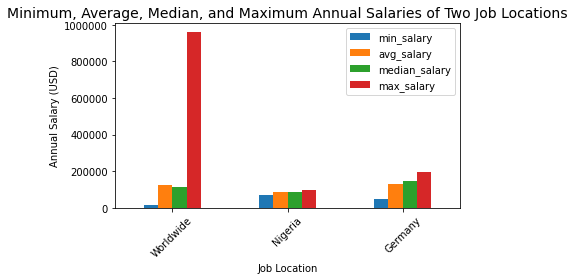

In [78]:
min_mean_median_max_query_result.plot(x="job_location", y=["min_salary", "avg_salary", "median_salary", "max_salary"], kind="bar")
plt.xticks(rotation=45)
plt.xlabel("Job Location")
plt.ylabel("Annual Salary (USD)")
plt.title("Minimum, Average, Median, and Maximum Annual Salaries of Two Job Locations", fontsize=14)
plt.ticklabel_format(style="plain", axis="y")
plt.tight_layout()

---